In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda:0


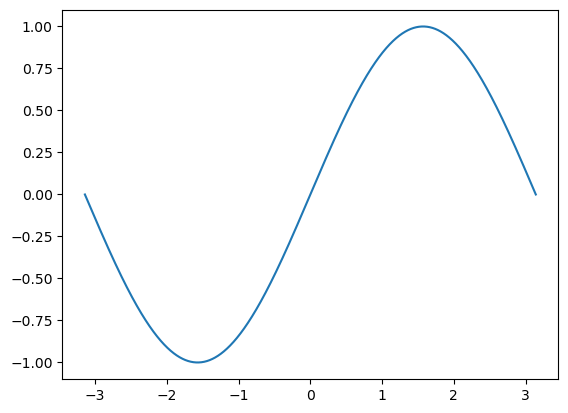

In [2]:
x = np.linspace(-np.pi, np.pi, 2000).astype(np.float32)
y = np.sin(x)
plt.plot(x, y)

In [3]:
x = torch.from_numpy(x).to(device)
y = torch.from_numpy(y).to(device)

a = torch.randn((), device = device, requires_grad = True)
b = torch.randn((), device = device, requires_grad = True)
c = torch.randn((), device = device, requires_grad = True)
d = torch.randn((), device = device, requires_grad = True)

print(a, b, c, d)

tensor(0.3376, device='cuda:0', requires_grad=True) tensor(0.8138, device='cuda:0', requires_grad=True) tensor(1.4112, device='cuda:0', requires_grad=True) tensor(-1.1005, device='cuda:0', requires_grad=True)


In [4]:
lr = 1e-3

for i in range(2000):
  y_pred = a + b * x + c * x**2 + d * x**3

  loss = ((y - y_pred)**2).mean()
  loss.backward()

  with torch.no_grad():
    a -= lr * a.grad
    b -= lr * b.grad
    c -= lr * c.grad
    d -= lr * d.grad

    a.grad = None
    b.grad = None
    c.grad = None
    d.grad = None

print(a, b, c, d)

tensor(0.0162, device='cuda:0', requires_grad=True) tensor(0.8692, device='cuda:0', requires_grad=True) tensor(-0.0028, device='cuda:0', requires_grad=True) tensor(-0.0951, device='cuda:0', requires_grad=True)


In [5]:
transforms_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transforms_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.FashionMNIST('fminst', train = True, download = True, transform = transforms_train)
test_dataset = torchvision.datasets.FashionMNIST('fmnist', train = False, download = True, transform = transforms_test)

num_workers = 2
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = False)

0.7%

100.0%


Extracting fminst/FashionMNIST/raw/train-images-idx3-ubyte.gz to fminst/FashionMNIST/raw


100.0%


Extracting fminst/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fminst/FashionMNIST/raw




9.6%

100.0%


Extracting fminst/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fminst/FashionMNIST/raw



100.0%


Extracting fminst/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fminst/FashionMNIST/raw



100.0%


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100.0%


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100.0%


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100.0%

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [6]:
class MlpNet(torch.nn.Module):
  def __init__(self, in_shape, hidden_features, out_classes):
    super().__init__()
    self.hidden_layer = torch.nn.Linear(np.product(in_shape), hidden_features)
    self.output_layer = torch.nn.Linear(hidden_features, out_classes)

  def forward(self, x):
    y = torch.nn.Flatten()(x)
    y = self.hidden_layer(y)
    y = torch.nn.ReLU()(y)
    y = self.output_layer(y)

    return y

model = MlpNet((1, 28, 28), 64, 10).to(device)
print(model)

MlpNet(
  (hidden_layer): Linear(in_features=784, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=10, bias=True)
)


In [7]:
print(len(train_dataset))

60000


In [8]:
epoch_count = 10
lr = 1e-3

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

for epoch in range(epoch_count):
  loss_acum = np.array([], dtype = np.float32)

  for data in train_loader:
    images = data[0].to(device)
    labels = torch.nn.functional.one_hot(data[1], 10).float().to(device)

    pred = model(images)
    loss = loss_func(pred, labels)
    loss_acum = np.append(loss_acum, loss.cpu().detach().numpy())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  print(f'Epoch: {epoch}, Loss: {np.mean(loss_acum)}')

Epoch: 0, Loss: 0.6997090578079224
Epoch: 1, Loss: 0.4680134654045105
Epoch: 2, Loss: 0.42975547909736633
Epoch: 3, Loss: 0.40394771099090576
Epoch: 4, Loss: 0.3873586356639862
Epoch: 5, Loss: 0.37139061093330383
Epoch: 6, Loss: 0.36035579442977905
Epoch: 7, Loss: 0.3480292856693268
Epoch: 8, Loss: 0.34072911739349365
Epoch: 9, Loss: 0.33304816484451294


In [11]:
model.eval()
correct_predictions = 0
total_predictions = 0

for data in test_loader:
  images = data[0].to(device)
  labels = data[1].to(device)

  pred = model(images)
  label_pred = torch.argmax(pred, dim = 1)

  correct_predictions += torch.sum(labels == label_pred)
  total_predictions += images.shape[0]

print(f'Accuracy: {correct_predictions / total_predictions}')

Accuracy: 0.8605999946594238
